In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "serif"
#from matplotlib.colors import LogNorm
#import matplotlib.colors as colors
#from mpl_toolkits.basemap import Basemap
#from matplotlib.animation import FuncAnimation
#from mpl_toolkits.axes_grid.inset_locator import inset_axes

import numpy as np
import sys, os
from netCDF4 import Dataset#, MFDataset
#from datetime import datetime
#import scipy.signal as sig
#from scipy.ndimage import gaussian_filter
#import scipy.interpolate as itp
#from PIL import Image, ImageDraw
import json
import pandas as pd
import scipy.optimize as opt

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = KRYPTON+"local_ruchba/"

In [26]:
simul = "luckym2"
if simul in ['luckyt']:
    season = "_win"
    suff = season
else:
    season = ""
    suff = "-b"
    
#grid_file = KRYPTON+"/lucky_corgrd.nc"
#doms_file = "../NRJ_flux_diag/subdomains_lucky.json"
dirpic = 'pictures/paper/' #modal_conv_scatter/'#
dosavefig = False

#filscat = KRYPTON+'{0}_modemap/{0}_mode_scatdiag.nc'.format(simul)
filcsv = "./{0}_diagscat{1}.csv".format(simul,suff)
#data_Fa14 = KRYPTON+"Tide_Conv/Falahat_etal_2014_ModalConvM2.nc"

#with open(doms_file, "r") as fp:
#    mydoms = json.load(fp)
      
## unfold subdomains
#doms, nams = [], []
#for key,val in mydoms.items():
#    if key == "ridges":
#        for ido,dom in enumerate(val):
#            doms.append(dom)
#            nams.append(key.rstrip("s")+str(ido+1))
#    else:
#        doms.append(val)
#        nams.append(key)

# load dataframe

#datfra = pd.read_csv(filcsv, header=[0,1], index_col=0)#, converters={'Cmn': eval})
datfra = pd.read_pickle(filcsv.replace("csv","pkl"))
nmod = len(datfra)

rho0 = 1025


/home/lahaye/Coding/virtual_envs/py3_libra_lab/lib/python3.5/site-packages/pandas/core/indexes/base.py:162: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)
/home/lahaye/Coding/virtual_envs/py3_libra_lab/lib/python3.5/site-packages/pandas/core/indexes/base.py:162: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


In [18]:
filcsv

'./luckym2_diagscat-b.csv'

In [35]:
dom = "ridge2"
scal = 1e3 # mW/m^2
cmn = np.zeros((nmod,nmod))
for imod in range(nmod):
    cmn[imod,imod+1:] = datfra["Cmn",dom][imod]
cmn = (cmn - cmn.T)*scal
cbt = datfra["Cmn",dom][0] * scal
cbc = cmn[1:,1:].sum(axis=0)
divf = datfra["divF",dom][1:].values*scal
disstot = datfra["Diss_tot",dom][1:].values*scal
dissres = datfra["Diss_res",dom][1:].values*scal
imods = np.arange(1,nmod)

if False:
    fig = plt.figure()
    ax = plt.gca()
    ax.step(imods, cbt, where="mid")
    ax.step(imods, cbc, where="mid")  
    ax.step(imods, cbc+cbt, where="mid")
    ax.step(imods, divf, where="mid")
    ax.step(imods, disstot, where="mid")
    ax.step(imods, dissres, where="mid")
    ax.grid(True)

## Do the plot

In [40]:
dosavefig=True

estimated NRJ in higher modes: 2.57e-02 kJ/m^2


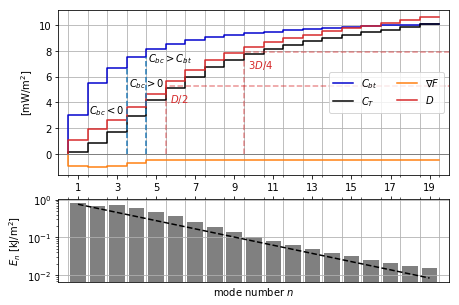

In [41]:
### That's the plot. TODO: add btrop/bcline decomposition at the end of the plot

whr = "pre"
cumplot = lambda x: np.r_[0, x.cumsum()]
imodplot = np.r_[imods, imods[-1]+1]-.5
labs = {"cbt":r"$C_{bt}$", "ctot":r"$C_T$", "divF":r"$\nabla F$", "dissres":r"$D$"}
if simul in ['luckyt']:
    whatE = "KE"
else:
    whatE = "Etot"

fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, gridspec_kw = {'height_ratios':[2, 1]}, figsize=(7,5))
ax = axs[0]
ax.step(imodplot, cumplot(cbt), where=whr, label=labs["cbt"], color="mediumblue")
#ax.step(imods, cbc.cumsum(), where="mid", label="cbc")
ax.step(imodplot, cumplot(cbt+cbc), where=whr, label=labs["ctot"], color="k")  
ax.step(imodplot, cumplot(divf), where=whr, label=labs["divF"], color="tab:orange")
#ax.step(imods, disstot.cumsum(), where=whr, label="disstot")
ax.step(imodplot, cumplot(dissres), where=whr, label=labs["dissres"], color="tab:red")
ax.legend(ncol=2)#, loc="lower right")

idup = np.where(dissres.cumsum()<(dissres.sum()/2.))[0][-1] #abs(dissres.cumsum()-dissres.sum()/2.).argmin()
ax.plot([imodplot[idup+1], imodplot[idup+1], nmod], np.array([0, 1, 1])*(dissres.sum())/2., "--", color='tab:red', alpha=.5)
ax.text(imodplot[idup+1]+.2, dissres.sum()*.45, r"$D/2$", ha="left", va="top", color="tab:red")
idup = np.where(dissres.cumsum()<(dissres.sum()*.75))[0][-1] #abs(dissres.cumsum()-dissres.sum()/2.).argmin()
#ax.plot([0, imodplot[idup+1], imodplot[idup+1]], np.array([1, 1, 0])*(dissres.sum())*.75, "--", color='tab:red', alpha=.5)
ax.plot([imodplot[idup+1], imodplot[idup+1], nmod], np.array([0, 1, 1])*(dissres.sum())*.75, "--", color='tab:red', alpha=.5)
ax.text(imodplot[idup+1]+.2, dissres.sum()*.70, r"$3D/4$", ha="left", va="top", color="tab:red")
if dom not in ["seamounts","ridge2"]:
    icup = np.where(cbt>cbc)[0][-1]
    icne = np.where(cbc>0)[0][0]-1
    ax.plot(np.ones(2)*imodplot[icup+1], [0, cbt[:icup].sum()], "--", color="tab:blue")
    ax.plot(np.ones(2)*imodplot[icne+1], [0, cbt[:icne+1].sum()], "--", color="tab:blue")
    ax.text(imodplot[icup+1]+.1, cbt[:icup+2].sum(), r"$C_{bc}>C_{bt}$", ha="left", va="top")
    ax.text(imodplot[icne+1]+.1, (cbt+cbc/2.)[:icne+2].sum(), r"$C_{bc}>0$", ha="left", va="center")
    ax.text(imodplot[icne+1]-.1, (cbt+cbc)[:icne+2].sum(), r"$C_{bc}<0$", ha="right", va="center")
elif dom == "seamounts":
    icne = np.where(cbc>0)[0][0]-1
    ax.plot(np.ones(2)*imodplot[icne+1], [cbt[:icne+1].sum(), ax.get_ylim()[1]], "--", color="tab:blue")
    ax.text(imodplot[icne+1]+.1, (cbt+cbc)[:icne+2].sum()+10, r"$C_{bc}>0$", ha="left", va="center", rotation=30)
    ax.text(imodplot[icne+1]+.3, (cbt+cbc)[:icne+2].sum()+10, r"$C_{bc}<0$", ha="right", va="center", rotation=30)
elif dom == "ridge2":
    icup = np.where(cbt>cbc)[0][-1]
    icne = np.where(cbc>0)[0][0]-1
    ax.plot(np.ones(2)*imodplot[icup+1], [0, cbt[:icup+1].sum()], "--", color="tab:blue")
    ax.plot(np.ones(2)*imodplot[icne+1], [0, cbt[:icne+1].sum()], "--", color="tab:blue")
    ax.text(imodplot[icup+1]+.1, cbt[:icup+2].sum()*0.98, r"$C_{bc}>C_{bt}$", ha="left", va="top")
    ax.text(imodplot[icne+1]+.1, (cbt+cbc*.45)[:icne+2].sum(), r"$C_{bc}>0$", ha="left", va="center")
    ax.text(imodplot[icne+1]-.1, (cbt+cbc*.9)[:icne+2].sum(), r"$C_{bc}<0$", ha="right", va="center")
    ax.axhline(0, color="grey", linewidth=1)

for ax in axs:
    ax.grid(True, axis="y")
    ax.set_xticks(imodplot, minor=True)
    ax.grid(False, which="major", axis="x")
    ax.grid(True, which="minor", axis="x")
axs[1].set_xticks(np.arange(1,nmod, 2), minor=False)
axs[1].xaxis.tick_top()
ax.set_xlim([0, nmod])

ax = axs[1]
ax.bar(imods, datfra[whatE,dom][1:], color="grey", log=True)
#ax.set_yscale('log')
# interpolation for Etot
if dom == "full":
    cbone = datfra[whatE,dom][1:]
    fun = lambda x, a, b: a*np.exp(-x/b) #a/(x-1)
    fan = lambda pars: 1 - fun(imods,pars[0],pars[1])/cbone # relative or absolute ?
    res = opt.least_squares(fan, x0=[1,3])
    popt = res.x
else:
    popt = np.array([ 0.97589068,  3.98368693])
#popt, pcov = opt.curve_fit(fun, imods[:], datfra[whatE,dom][1:])
ax.plot(imods[:], fun(imods[:],*popt), "--", color="k")
print("estimated NRJ in higher modes: {:.2e} kJ/m^2".format(popt.prod()*np.exp(-nmod/popt[1])) )
if dom == "full":
    ax.text(.98, .92, r"$a=$"+"{:.2f}\n".format(popt[0])+r"$b=$"+"{:.2f}".format(popt[1]) \
        , ha="right", va="top", transform=ax.transAxes, bbox=dict(facecolor="w", edgecolor="none"))
axs[0].set_ylabel('[mW/m$^2$]')
axs[1].set_ylabel('$E_n$ [kJ/m$^2$]')
axs[1].set_xlabel('mode number $n$')
#axs[1].set_ylim([1e-2, 5])

if dosavefig:
    fig.savefig(dirpic+"{0}_CuModBalance_{1}.pdf".format(simul+season,dom))

In [33]:
dosavefig=False

cbtrop 1.002593424640191
cbclin 0.5659891378117266
ctot 1.5685825624519176
divf 0.062460346200071085
diss 1.5061222162518466
cbtrop 37.50802561583903
cbclin -7.28583859910259e-16
ctot 37.508025615839024
divf 21.177943375242645
diss 16.330082240596365


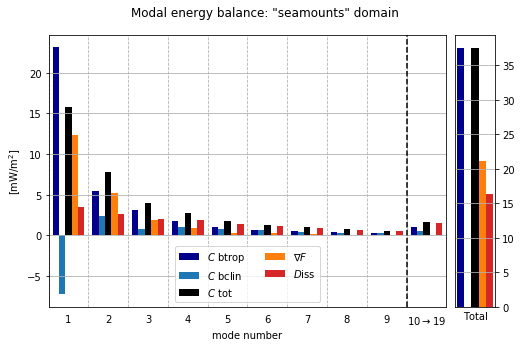

In [34]:
### Non-cumulative version

fields = ["cbtrop","cbclin","ctot","divf","diss"]
labs = [r"$C$ btrop", r"$C$ bclin",r"$C$ tot",r"$\nabla F$",r"$D$iss"]
cols = ["darkblue",'tab:blue',"black",'tab:orange','tab:red']

width = .8
nmodplot = min(10, nmod)

#prov = ctmn[do] - ctmn[do].T
cbclin = cbc #prov[1:,1:].sum(axis=0)
cbtrop = cbt #ctmn[do][0,1:]
ctot = cbt+cbc #cbclin+cbtrop
#divf = divfmoy[do][1:]
diss = dissres #ctot-divf

fig, axs = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[nmodplot, 1]}, figsize=(8,5))
ax = axs[0]
for imod in range(1,nmodplot):
    for ifi,fie in enumerate(fields):
        lab = labs[ifi] if imod==1 else None
        ax.bar(imod-width/2+width*(ifi+.5)/len(fields), eval(fie)[imod-1], width/len(fields), 
               color=cols[ifi], label=lab)

# add group of higher modes
if nmodplot < nmod:
    ax.axvline(imod+.5, color="k", linestyle="--")
    imod += 1
    for ifi,fie in enumerate(fields):
        lab = None
        ax.bar(imod-width/2+width*(ifi+.5)/len(fields), eval(fie)[nmodplot:].sum(), width/len(fields), 
               color=cols[ifi], label=lab)
        print(fie,eval(fie)[nmodplot:].sum())
    
#ax.set_xticks(ind)
#ax.set_xticklabels(nams+['Total'], rotation=27, y=.03, ha="center")
ax.grid(True)
ax.set_xticks(np.r_[np.arange(1,nmodplot),nmodplot])
ax.set_xticklabels([str(ii) for ii in range(1,nmodplot)]+[str(nmodplot)+r"$\rightarrow$"+str(nmod-1)])
ax.grid(which="major", axis="x", linestyle="none")
ax.set_xticks(.5+np.arange(nmodplot), minor=True)
ax.grid(which="minor", axis="x", linestyle="--")
ax.tick_params(bottom=False, which="both")
ax.legend(ncol=2)
#plt.title(simul.upper()+": NRJ balance per subdomain")
fig.suptitle('Modal energy balance: "{}" domain'.format(dom), y=.96)
ax.set_xlabel("mode number")
ax.set_xlim([0.5, nmodplot+.5])
ax.set_ylabel(r'[mW/m$^2$]')

ax = axs[1]
for ifi,fie in enumerate(fields):
    lab = None
    ax.bar(imod-width/2+width*(ifi+.5)/len(fields), eval(fie).sum(), width/len(fields), 
           color=cols[ifi], label=lab)
    print(fie,eval(fie).sum())
ax.set_xticks([])
ax.set_xlabel('Total', va="top")
ax.yaxis.tick_right()
ax.grid(True)

fig.subplots_adjust(wspace=.04)

if dosavefig:
    fig.savefig(dirpic+"{0}_ModBal_{1}.pdf".format(simul+season,dom), magnification="auto", bbox_inches="tight")


## Distribution of barotropic conversion among modes

In [145]:
nmod

20

In [150]:
datfra["Cmn"]["full"][0]

array([  2.11773517e-03,   1.00630543e-03,   6.28861265e-04,
         4.15297330e-04,   2.72319086e-04,   1.93965129e-04,
         1.45511622e-04,   1.06247022e-04,   8.04777862e-05,
         6.47578114e-05,   5.44286516e-05,   4.44923573e-05,
         3.71289896e-05,   3.11933165e-05,   2.73457442e-05,
         2.30581726e-05,   2.05203337e-05,   1.81848051e-05,
         1.60161464e-05])

In [156]:
doms = ["full", "seamounts", "ridge2"]

for do in doms:
    cbt = datfra["Cmn",do][0] * 1e3 # mW/m^2
    cbtot = cbt.sum()
    print('Domain {0}, Ct total: {1:.2e}'.format(do, cbtot))
    print("\t mode 1/tot: {:.2e}".format(cbt[0]/cbtot))
    print("\t mode {0}/tot: {1:.2e}".format(nmod-1, cbt[-1]/cbtot))
    print("\t mode 1/{0}: {1:.2e}".format(nmod-1, cbt[-1]/cbt[0]))
    imod = 4
    print("\t sum 1->{0} over tot: {1:.2e}".format(imod, cbt[:imod].sum()/cbtot))    
    print("\t sum {0}->{2} over tot: {1:.2e}".format(imod+1, cbt[imod:].sum()/cbtot, nmod-1))
    print("\t sum {0}->{2} over 1->{0}: {1:.2e}".format(imod+1, cbt[imod:].sum()/cbt[:imod].sum(), nmod-1))
    imod = 9
    print("\t sum 1->{0} over tot: {1:.2e}".format(imod, cbt[:imod].sum()/cbtot))    
    print("\t sum {0}->{2} over tot: {1:.2e}".format(imod+1, cbt[imod:].sum()/cbtot, nmod-1))
    print("\t sum {0}->{2} over 1->{0}: {1:.2e}".format(imod+1, cbt[imod:].sum()/cbt[:imod].sum(), nmod-1))

Domain full, Ct total: 5.30e+00
	 mode 1/tot: 3.99e-01
	 mode 19/tot: 3.02e-03
	 mode 1/19: 7.56e-03
	 sum 1->4 over tot: 7.86e-01
	 sum 5->19 over tot: 2.14e-01
	 sum 5->19 over 1->5: 2.72e-01
	 sum 1->9 over tot: 9.36e-01
	 sum 10->19 over tot: 6.36e-02
	 sum 10->19 over 1->10: 6.79e-02
Domain seamounts, Ct total: 3.75e+01
	 mode 1/tot: 6.17e-01
	 mode 19/tot: 1.63e-03
	 mode 1/19: 2.64e-03
	 sum 1->4 over tot: 8.91e-01
	 sum 5->19 over tot: 1.09e-01
	 sum 5->19 over 1->5: 1.22e-01
	 sum 1->9 over tot: 9.66e-01
	 sum 10->19 over tot: 3.35e-02
	 sum 10->19 over 1->10: 3.47e-02
Domain ridge2, Ct total: 1.01e+01
	 mode 1/tot: 2.96e-01
	 mode 19/tot: 4.46e-03
	 mode 1/19: 1.51e-02
	 sum 1->4 over tot: 7.46e-01
	 sum 5->19 over tot: 2.54e-01
	 sum 5->19 over 1->5: 3.40e-01
	 sum 1->9 over tot: 9.16e-01
	 sum 10->19 over tot: 8.42e-02
	 sum 10->19 over 1->10: 9.19e-02


# Old stuff

estimated NRJ in higher modes: {:.2e} kJ/m^2 0.0121730862931
estimated conversion to higher modes: {:.2e} mW/m^2 -2.22578935199e-111


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


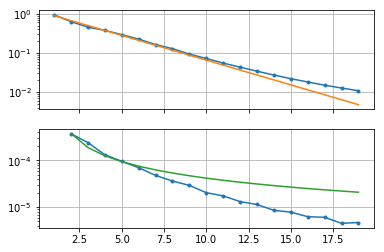

In [66]:
# plot fit for Cmn and energy 

fun = lambda x, a, b: a*np.exp(-x/b) #a/(x-1)

fig, axs = plt.subplots(2, 1, sharex=True)

ax = axs[0]
cbone = datfra["Etot", dom][1:]    
ax.plot(imods[:], cbone, ".-")
# f(x) = a*exp(-x/b) so I(x) = -a*b*exp(-x/b), hence int(nmax,inf) = -I(nmax) = a*b*exp(nmax/b)
popt, pcov = opt.curve_fit(fun, imods[:], cbone)
ax.plot(imods[:], fun(imods[:],*popt))
print("estimated NRJ in higher modes: {:.2e} kJ/m^2", popt.prod()*np.exp(-nmod/popt[1]))

ax = axs[1]
cbone = datfra["Cmn",dom][1]
ax.plot(imods[1:], cbone, ".-")
popt, pcov = opt.curve_fit(fun, imods[1:], cbone)
ax.plot(imods[:], fun(imods[:],*popt))
print("estimated conversion to higher modes: {:.2e} mW/m^2", popt.prod()*np.exp(-nmod/popt[1]))

fun = lambda x, a: a/(x-1)
popt, pcov = opt.curve_fit(fun, imods[1:], cbone)
ax.plot(imods[:], fun(imods[:],*popt))

for ax in axs:
    ax.grid(True)
    ax.set_yscale("log")

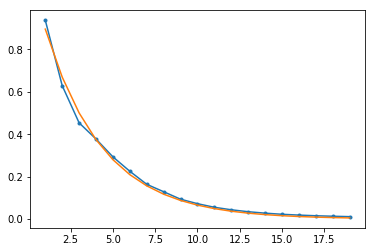

In [75]:
fun = lambda x, a, b: a*np.exp(-x/b) #a/(x-1)
cbone = datfra["Etot", dom][1:]    
popt, pcov = opt.curve_fit(fun, imods[:], cbone)
plt.plot(imods[:], cbone, ".-")
plt.plot(imods[:], fun(imods[:],*popt))

In [93]:
popt

array([ 0.97589068,  3.98368693])

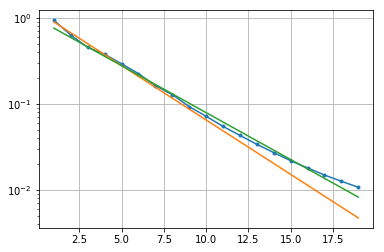

In [91]:
fun = lambda x, a, b: a*np.exp(-x/b) #a/(x-1)
fan = lambda pars: 1 - fun(imods,pars[0],pars[1])/cbone
res = opt.least_squares(fan, x0=popt-1)
res.x

plt.plot(imods[:], cbone, ".-")
plt.plot(imods[:], fun(imods[:],*popt))
plt.plot(imods[:], fun(imods[:],*res.x))
plt.grid(True)
plt.yscale('log')

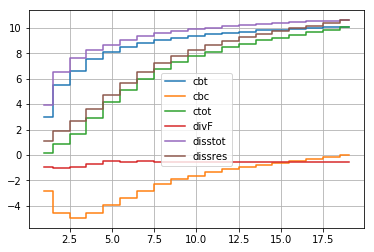

In [7]:
fig = plt.figure()
ax = plt.gca()
ax.step(imods, cbt.cumsum(), where="mid", label="cbt")
ax.step(imods, cbc.cumsum(), where="mid", label="cbc")
ax.step(imods, (cbt+cbc).cumsum(), where="mid", label="ctot")  
ax.step(imods, divf.cumsum(), where="mid", label="divF")
ax.step(imods, disstot.cumsum(), where="mid", label="disstot")
ax.step(imods, dissres.cumsum(), where="mid", label="dissres")
ax.grid(True)
ax.legend()

TypeError: slice indices must be integers or None or have an __index__ method

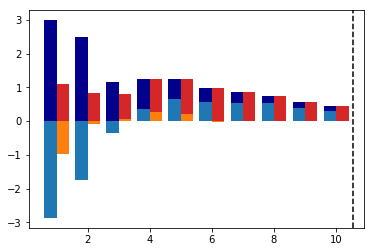

In [8]:
# barplot

fields = ["cbt","cbc","divf","dissres"]
ipos = {"cbt":0, "cbc":0, "divf":1, "dissres":1}
cols = {"cbt":"darkblue", "cbc":'tab:blue', "divf":'tab:orange',"dissres":'tab:red'}
labs = {key:key for key in fields}

width = .8
wdt = width/(max(ipos.values())+1)
xc = lambda imo,ipo: imo-width/2+wdt*(ipo+.5)
nmodshow = 10

fig = plt.figure()
ax = plt.subplot(111)
for imod in range(1,nmodshow+1):
    fie = "cbt"
    lab = labs[fie] if imod==1 else None
    ax.bar(xc(imod,ipos[fie]), cbt[imod-1], wdt, bottom=(cbc[imod-1]>0)*cbc[imod-1], color=cols[fie], label=lab)
    fie = "cbc"
    lab = labs[fie] if imod==1 else None
    ax.bar(xc(imod,ipos[fie]), cbc[imod-1], wdt, color=cols[fie], label=lab)
    fie = "dissres"
    lab = labs[fie] if imod==1 else None
    ax.bar(xc(imod,ipos[fie]), dissres[imod-1], wdt, bottom=(divf[imod-1]>0)*divf[imod-1], color=cols[fie], label=lab)
    fie = "divf"
    lab = labs[fie] if imod==1 else None
    ax.bar(xc(imod,ipos[fie]), divf[imod-1], wdt, color=cols[fie], label=lab)

ax.axvline(imod+.55, color="k", linestyle="--")
imod += 1.1
for ifi,fie in enumerate(fields):
    fie = "cbt"
    ax.bar(xc(imod,ipos[fie]), cbt[imod-1:].sum(), wdt, bottom=cbc[imod-1:].sum(), color=cols[fie], label=lab)
    fie = "cbc"
    ax.bar(xc(imod,ipos[fie]), cbc[imod-1:].sum(), wdt, color=cols[fie], label=lab)
    fie = "dissres"
    ax.bar(xc(imod,ipos[fie]), dissres[imod-1:].sum(), wdt, bottom=divf[imod-1:].sum(), color=cols[fie], label=lab)
    fie = "divf"
    ax.bar(xc(imod,ipos[fie]), divf[imod-1:].sum(), wdt, color=cols[fie], label=lab)
        
#ax.set_xticks(ind)
#ax.set_xticklabels(nams+['Total'], rotation=27, y=.03, ha="center")

plt.legend()
